# Soda Python Scan - Demo

TODOS
- **Soda mit Python**: https://docs.soda.io/soda-library/programmatic.html
    - Failed row samples: https://docs.soda.io/soda/route-failed-rows.html
    - `scan_result` object contains all the scan results information
- **Soda Cloud**: https://docs.soda.io/soda-library/install.html
    - Examine failed row samples: https://docs.soda.io/soda-cloud/failed-rows.html
- Soda Agent
    - Set up Soda-hosted agent: https://docs.soda.io/soda-agent/managed-agent.html
    - Deploy Soda Agent: https://docs.soda.io/soda-agent/deploy.html

- **Usecases**: https://docs.soda.io/soda/use-case-guides.html
    - Test data in a pipeline
    - Test data before migration
    - Test data during development
    - Automate monitoring
- API keys: https://docs.soda.io/soda-cloud/api-keys.html

- **Check Arten**
    - Checks mit Build-in metrics
    - Anomaly detection checks
    - Custom checks
    - Schema checks

- Check suggestions (for data sources GCP BigQuery, PostgresSQL, Snowflake): https://docs.soda.io/soda-library/check-suggestions.html -> Vorschläge für mögliche Checks die man berücksichtigen könnte
- Soda Cloud Account -> Soda GPT um Soda Checks zu schreiben
- Dashboard customizable; Activate anomaly dashboards
- Alert notification settings
- Roles and rights
- Data source support: BigQuery, Snowflake, Databricks, MYSQL, PostgreSQL etc.
- Integrate Soda into other tools: Jira, Github, dbt, etc.
- Exit codes: https://docs.soda.io/soda-library/programmatic.html#scan-exit-codes

## Alle nötigen Libraries installieren und importieren

In [ ]:
!pip install soda-core==3.3.5
!pip install soda-core-postgres==3.3.5
!pip install pandas==2.2.2
!pip install psycopg2-binary==2.9.9

In [19]:
from soda.scan import Scan
from soda.sampler.sampler import Sampler
from soda.sampler.sample_context import SampleContext
import pandas as pd
import psycopg2
from IPython.display import Code, Image
from datetime import datetime
import json
import os 

## Vorbereitung von Demo-Daten (siehe auch READM.md)
- Lade zuerst die Demo-Daten aus https://github.com/sodadata/tutorial-demo-project/tree/main/data/ny_bus_breakdown herunter
    - Beschreibung der Daten unter: https://data.cityofnewyork.us/Transportation/Bus-Breakdown-and-Delays/ez4e-fazm/about_data
- Führe PostgresSQL Server mit Docker aus:
  ```
  sudo docker run --name postgresql1 -e POSTGRES_PASSWORD=test -v ${HOME}/postgres-data/:/var/lib/postgresql/data -p 5432:5432 -d postgres:15.2
  ```
- Importiere die CSV Datei local in eine Postgres Datenbank (`incident_number` column muss als `varchar` importiert werden)
    - database name: `demo`
    - schema: `public`
    - table name: `bus_breakdown_and_delays`

## Visualisierung von Demo-Daten
- Verbindung zur PostgresSQL Datenbank aufbauen und Laden der Daten in ein Pandas Dataframe

In [2]:
host = 'localhost'
database = 'demo'
user = 'postgres'
password = 'test'

def connect():
    """Connect to database"""
    conn = None
    try:
        print('Connecting...')
        conn = psycopg2.connect(
            host=host,
            database=database,
            user=user,
            password=password)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    print('All good, Connection successful!')
    return conn

def sql_to_dataframe(conn, query, column_names):
    """
    Import data from a PostgreSQL database using a SELECT query 
    """
    cursor = conn.cursor()
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print('Error: %s' % error)
        cursor.close()
        return 1
    # The execute returns a list of tuples:
    tuples_list = cursor.fetchall()
    cursor.close()
    # Now we need to transform the list into a pandas DataFrame:
    df = pd.DataFrame(tuples_list, columns=column_names)
    return df

In [3]:
columns = ['school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number',
           'reason', 'schools_serviced', 'occured_on', 'created_on', 'boro',
           'bus_company_name', 'how_long_delayed', 'number_of_students_on_the_bus',
           'has_contractor_notified_schools', 'has_contractor_notified_parents',
           'have_you_alerted_opt', 'informed_on', 'incident_number',
           'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek']

query = """ SELECT * 
            FROM bus_breakdown_and_delays
        """

conn = connect()
bus_df = sql_to_dataframe(conn, query, columns)
conn.close()

bus_df

Connecting...
All good, Connection successful!


,school_year,busbreakdown_id,run_type,bus_no,route_number,reason,schools_serviced,occured_on,created_on,boro,...,how_long_delayed,number_of_students_on_the_bus,has_contractor_notified_schools,has_contractor_notified_parents,have_you_alerted_opt,informed_on,incident_number,last_updated_on,breakdown_or_running_late,school_age_or_prek
0,2017-2018,1363818,Special Ed AM Run,19250,X414,Heavy Traffic,12486,2017-08-01 07:15:00,2017-08-01 07:22:00,Bronx,...,25-30 MIN,0,Yes,Yes,Yes,2017-08-01 07:22:00,,2017-08-01 07:22:55,Running Late,School-Age
1,2017-2018,1363819,Pre-K/EI,12495,B0203A,Other,C244,2017-08-01 07:21:00,2017-08-01 07:24:00,Brooklyn,...,15 MINS,0,Yes,Yes,Yes,2017-08-01 07:24:00,,2017-08-01 09:42:39,Running Late,Pre-K
2,2017-2018,1363820,Special Ed AM Run,31338,X105,Heavy Traffic,12084,2017-08-01 07:20:00,2017-08-01 07:26:00,Bronx,...,25-30 MIN,3,Yes,Yes,Yes,2017-08-01 07:26:00,,2017-08-01 07:26:38,Running Late,School-Age
3,2017-2018,1363821,Pre-K/EI,1050,GRA1,Other,C956,2017-08-01 07:24:00,2017-08-01 07:27:00,Queens,...,15-20MINS,8,Yes,Yes,Yes,2017-08-01 07:27:00,,2017-08-01 07:28:04,Running Late,Pre-K
4,2017-2018,1363822,Pre-K/EI,2604,NYM-2,Heavy Traffic,E203,2017-08-01 07:31:00,2017-08-01 07:28:00,Bronx,...,20 MINS,5,Yes,Yes,No,2017-08-01 07:28:00,,2017-08-01 07:28:17,Running Late,Pre-K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,2017-2018,1368830,Special Ed AM Run,5791D,Q690,Heavy Traffic,30502,2017-09-19 07:57:00,2017-09-19 07:58:00,Queens,...,16-30 Min,12,Yes,Yes,No,2017-09-19 07:58:00,,1900-01-01 00:00:00,Running Late,School-Age
199994,2015-2016,1213955,Pre-K/EI,9309,1,Heavy Traffic,S188,2015-09-10 08:10:00,2015-09-10 08:19:00,Bronx,...,15 minutes,7,Yes,No,No,2015-09-10 08:19:00,,2015-09-10 08:19:28,Running Late,Pre-K
199995,2015-2016,1218292,Pre-K/EI,730,3,Mechanical Problem,C037,2015-09-30 13:43:00,2015-09-30 13:47:00,Bronx,...,25,0,Yes,Yes,Yes,2015-09-30 13:47:00,,2015-09-30 13:47:38,Running Late,Pre-K
199996,2015-2016,1225246,Special Ed AM Run,1309,J737,Heavy Traffic,75003,2015-10-27 07:51:00,2015-10-27 08:08:00,Manhattan,...,20,0,Yes,Yes,Yes,2015-10-27 08:08:00,,2015-10-27 08:32:23,Running Late,School-Age


## Soda Cloud einrichten und API key erstellen
- Erstelle einen Soda account (free 45-day trial) unter https://cloud.soda.io/signup -> Eingloggen
- Navigiere zum **your avatar** > **Profile** und clicke auf **API keys** Tab
- Clicke auf das **+** Icon und generiere ein neues API key, secret Paar und speichere die Information local

## Soda Core mit Demo-Datenbank und Soda Cloud verbinden
- `configuration.yml` Datei enthält alle Information um sich mit der Datenbank (`data_source`) mit Soda zu verbinden
- Auch Information, um sich mit den Soda Cloud zu verbinden können hier eingetragen werden (`soda_cloud`)
- Ersetze `api_key_id` und `api_key_secret` in `configuration.yml` mit den eigenen erstellten Werten

In [4]:
# Display connection configuration yml file
Code(filename='./configuration.yml', language='YAML')

data_source demo_datasource:
  type: postgres
  host: localhost
  port: "5432"
  username: postgres
  password: test
  database: demo
  schema: public

soda_cloud:
  host: cloud.soda.io
  api_key_id: your_api_key
  api_key_secret: your_api_key_secret

## Definiere Metrics und Checks mit Soda Checks Language (SodaCL)
- Checks werden in ein YAML File defniert: Es gibt verschiedene Arten von Checks, die definiert werden können
- `Built-in Metrics` (zusammen mit ein Threshold Wert) können verwendet werden, um Checks zu definieren (es gibt über 25 verschiedene Built-in Metrics)
    - Im Bsp. werden 5 verschiedene Build-in Metrics verwendet
        - `row_count`: überprüft die Daten auf ausreichende Einträge
        - `missing_count`: überprüft eine Spalte auf fehlende Werde
        - `duplicate_count`: überprüft eine Spalte auf duplikate Werte
        - `freshness`: überprüft die Daten auf Aktualität mit Referenzvariable `NOW` (default: current_timestamp) unter Berücksichtigung einer Date/Timestamp Spalte
        - `invalid count`: testet, ob eine Spalte nicht-valide Werte enthält (valid values können definiert werden)
- `Custom Checks`: Checks, die nicht mit Built-in Metrics definiert werden können, können als Custom Checks durch Verwendung von `User-defined checks` und `Failed rows checks` definiert werden
    - `User-defined checks`: ermöglichen common-table expressions (CTE) oder SQL queries zu erstellen, die Soda Library während des Scans verwendet
    - `Failed rows checks`: können verwendet werden, um Einträge, die im User-defined check fehlgeschlagen sind an Soda Cloud zu senden
    - Im Bsp. wird als Custom Check definiert, die Prüft, ob für alle Einträge jeweil der Datum-Wert von `last_updated_on` Spalte größer oder gleich der Datum-Wert von `created_on` Spalte ist (fehlgeschlagene Einträge werden an Soda Cloud gesendet)
- `Schema Checks`: können verwendet werden, um das Schema der Daten (z.B. Präsenz von bestimmten Spalten) zu prüfen
- `warn` oder `fail`: Für die definierten Checks können Alert Levels definiert werden

In [5]:
# Display checks configuration yml file
Code(filename='./demo_tests.yml', language='YAML')

# Checks for bus_breakdown_and_delays table in postgres

checks for bus_breakdown_and_delays:
# Built-in metrics:
  - row_count > 0
  - missing_count(busbreakdown_id) = 0
  - duplicate_count(busbreakdown_id) = 0
  - freshness(last_updated_on::timestamp) < 1d
  - invalid_count(breakdown_or_running_late) = 0:
      valid values: [Running Late, Breakdown]

# Custom metric
  - last_updated_on_after_created_on = 0:
      last_updated_on_after_created_on query: |
        SELECT COUNT(*) 
        FROM bus_breakdown_and_delays 
        WHERE last_updated_on >= created_on
      failed rows query: |
        SELECT * 
        FROM bus_breakdown_and_delays 
        WHERE last_updated_on < created_on

# Schema validation
  - schema:
      fail:
        when required column missing:
          - school_year
          - busbreakdown_id
          - incident_number
        when wrong column type:
          busbreakdown_id: Integer
      warn:
        when wrong column type:
          incident_number: Integer

## Scans programmatisch mit Python ausführen
- Soda library, die als Python library zur Verfügung steht kann benutzt werden, um Scan auszuführen
- Erstelle dafür ein `scan` Objekt der Klasse `soda.scan.Scan`
- scan Objekte können durch Verwendung der verschiedenen Methoden konfiguriert werden:
    - `add_configuration_yaml_file`: Mit der Methode kann eine `configuration.yml` (Connection Konfiguration) Datei für den scan Objekt gesetzt werden
        - Alternativ `add_configuration_yaml_str`: Definiere den Inhalt von `configuration.yml` Datei in ein String und übergebe den Wert an dieser Methode
    - `set_data_source_name`: Übergebe ein Name von data_source, welches in der `configuration.yml` Datei definiert ist
    - `set_scan_definition_name`: Spezifiziert den Scan Definition Name (wenn verbunden mit Soda Cloud), um Check Ergebnisse separat zu halten (z.B. dev, prod, staging)
    - `add_variables`: Variablen können mit der Methode für den scan Objekt gesetzt werden (hier wird z.B. die `NOW` Variable gesetzt, die für den freshness Check verwendet wird -> hier `"NOW": "2021-09-13 00:00:00"`und `freshness(last_updated_on) < 1d`: Check schlägt wenn die neueste Timestamp eintrag der Spalte älter als "2021-09-12 00:00:00" ist)
    - `add_sodacl_yaml_file`: mit der Methode können Check YAML Files an den scan Objekt übergeben werden
        - Alternativ `add_sodacl_yaml_str`: Definiere Cheks in ein String und übergebe den Wert an dieser Methode
    - `execute`: Führt den Scan aus und gibt ein Exitcode zurück (https://docs.soda.io/soda-library/programmatic.html#scan-exit-codes)
    - `set_verbose`: Führt den Scan in "verbose" Mode (mehr Information als Standard Mode) durch
    - `get_logs_text`: Gibt den Log-Output des Scans als String zurück

In [6]:
scan = Scan()

# Set scan definition name, equivalent to CLI -s option
scan.set_scan_definition_name("soda_demo")

scan.set_data_source_name("demo_datasource")

# Add config yml file
scan.add_configuration_yaml_file(file_path="./configuration.yml")

# Add variables
scan.add_variables({"NOW": "2021-09-13 00:00:00"})

# Add check YAML files 
scan.add_sodacl_yaml_file("./demo_tests.yml")

# Execute the scan
exit_code = scan.execute()
print("Exit code:", exit_code)

# Set logs to verbose mode, equivalent to CLI -V option
scan.set_verbose(True)

# Print results of scan
print(scan.get_logs_text())

Exit code: 2
INFO   | Soda Core 3.3.5
INFO   | Sending failed row samples to Soda Cloud
INFO   | Scan summary:
INFO   | 4/7 checks PASSED: 
INFO   |     bus_breakdown_and_delays in demo_datasource
INFO   |       row_count > 0 [PASSED]
INFO   |       missing_count(busbreakdown_id) = 0 [PASSED]
INFO   |       duplicate_count(busbreakdown_id) = 0 [PASSED]
INFO   |       invalid_count(breakdown_or_running_late) = 0 [PASSED]
INFO   | 1/7 checks WARNED: 
INFO   |     bus_breakdown_and_delays in demo_datasource
INFO   |       Schema Check [WARNED]
INFO   |         warn_column_type_mismatch[incident_number] expected(Integer) actual(character varying)
INFO   |         schema_measured = [school_year character varying, busbreakdown_id integer, run_type character varying, bus_no character varying, route_number character varying, reason character varying, schools_serviced character varying, occured_on character varying, created_on character varying, boro character varying, bus_company_name characte

['_Check__check_source_to_yaml', '_SchemaCheck__build_change_events', '_SchemaCheck__build_change_events_text', '_SchemaCheck__build_log_diagnostic_lines', '_SchemaCheck__list_of_texts', '_SchemaCheck__schema_diagnostics_texts', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_append_diffs', '_format_attributes', '_get_all_related_queries', 'add_outcome_reason', 'archetype', 'attributes', 'check_cfg', 'check_type', 'cloud_check_type', 'cloud_dict', 'column', 'create', 'create_definition', 'create_identities', 'create_identity', 'create_migrate_identities', 'data_source_scan', 'dict', 'evaluate', 'fail_result', 'failed_rows_sample_ref', 'force_send_results_to_cloud', 'get_cloud_diagnostics_dict', 'get_cloud_dict', 'get_dict', 'get_log_diagnostic_dict', 'get_log_diagnostic_lines', 'get_schema_violations', 'historic_descriptors', 'identity_datasource_part', 'is_deprecated', 'logs', 'measured_schema', 'metrics', 'name', 'outcome', 'outcome_reasons', 'partition', 'schema_comparator', 'warn_result']

### Checks Results Informationen in Soda Cloud
- Da wir in `configuration.yml` eine Connection mit Soda Cloud konfiguriert haben, können die Check Information in der Soda Cloud eingesehen werden
- Da wie für den Custom Check `Failed rows checks` definiert haben, werden alle Einträge die den Custom Check nicht erfüllen in der Soda Cloud angezeigt (siehe 1. Bild unten)
- Auch Informationen über Schema Checks werden angezeigt (siehe 2. Bild unten)

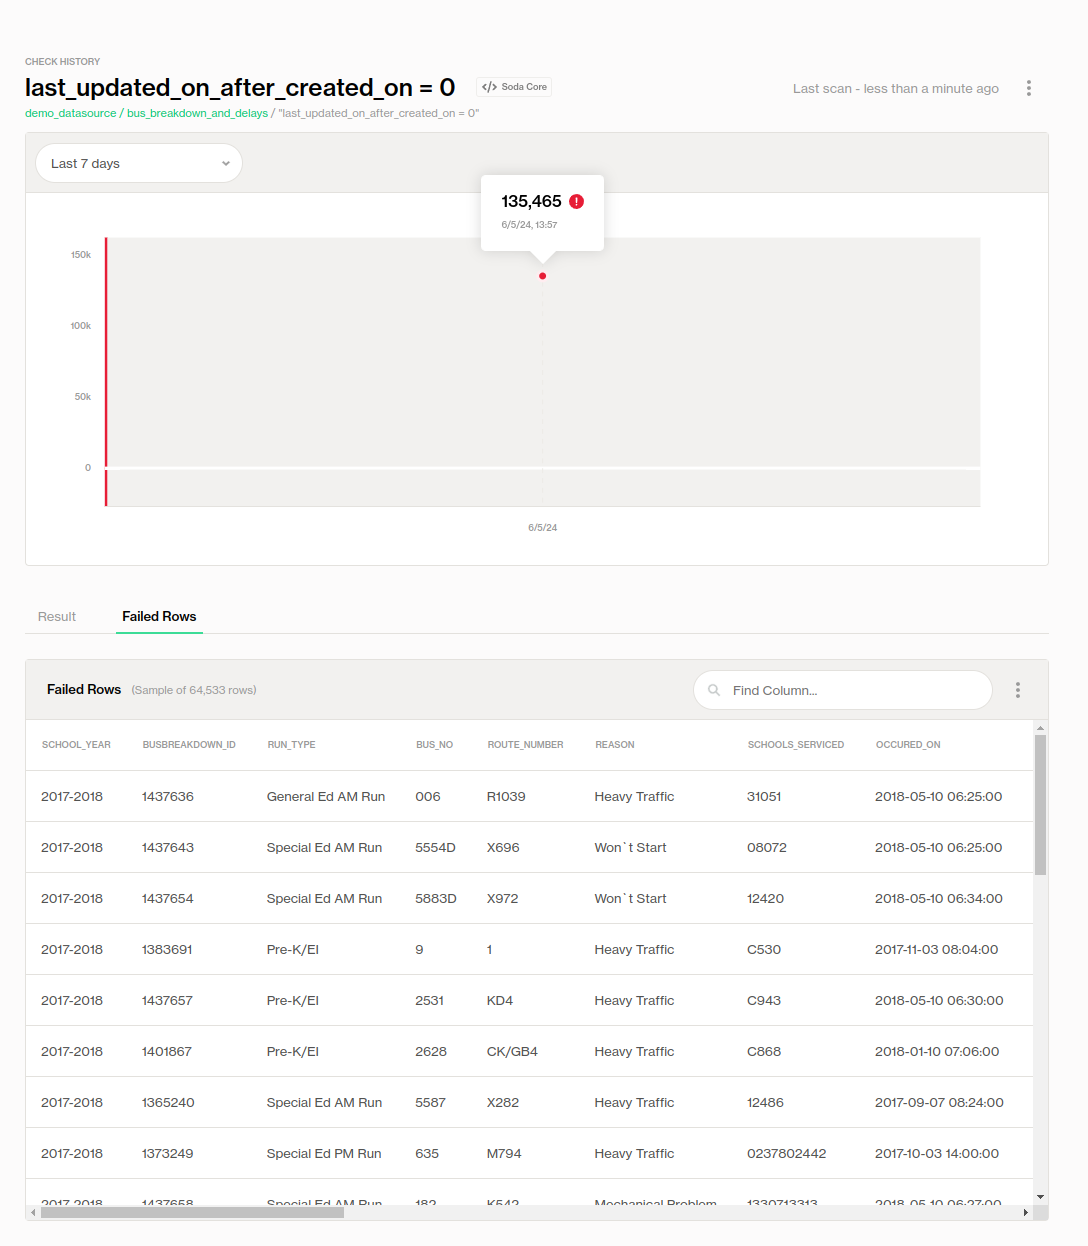

In [14]:
Image(filename='./images/soda_cloud_failed_rows.png')

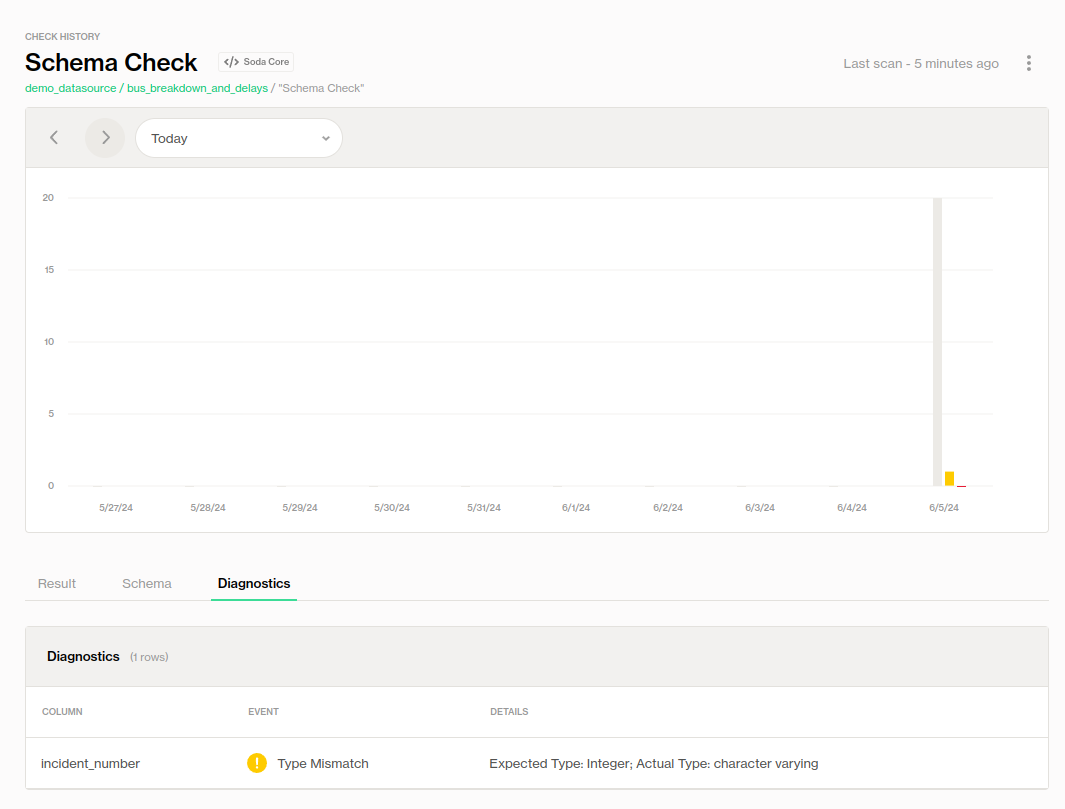

In [15]:
Image(filename='./images/soda_cloud_schema_check.png') 

### Scan Results speichern
- Um alle Information des Scan Results zu erhalten, kann die Methode `get_scan_results()` verwendet werden
- Diese Information können dann an beliebigen Orten gespeichert werden

In [7]:
scan.get_scan_results()

{'definitionName': 'soda_demo',
 'defaultDataSource': 'demo_datasource',
 'dataTimestamp': '2024-06-06T14:12:14+00:00',
 'scanStartTimestamp': '2024-06-06T14:12:14+00:00',
 'scanEndTimestamp': '2024-06-06T14:12:15+00:00',
 'hasErrors': False,
 'hasWarnings': True,
 'hasFailures': True,
 'metrics': [{'identity': 'metric-soda_demo-demo_datasource-bus_breakdown_and_delays-schema',
   'metricName': 'schema',
   'dataSourceName': 'demo_datasource',
   'tableName': 'bus_breakdown_and_delays',
   'partitionName': None,
   'columnName': None,
   'value': [{'columnName': 'school_year',
     'sourceDataType': 'character varying'},
    {'columnName': 'busbreakdown_id', 'sourceDataType': 'integer'},
    {'columnName': 'run_type', 'sourceDataType': 'character varying'},
    {'columnName': 'bus_no', 'sourceDataType': 'character varying'},
    {'columnName': 'route_number', 'sourceDataType': 'character varying'},
    {'columnName': 'reason', 'sourceDataType': 'character varying'},
    {'columnName': 

### Weitere Methoden des scan Objekts
- `scan.assert_no_error_logs()`, `scan.assert_no_checks_fail()`, `scan.assert_no_checks_warn_or_fail()`: AssertionError wird geworfen, falls der Scan Error-Logs / Check-Fails /Check-Fails und -Warnings enthält

- `scan.has_error_logs()`: Gibt ein Boolean Wert zurück, der beschreibt, ob das Log Errors beinhaltet
- `scan.get_error_logs_text()`: Gibt den Log Text zurück, falls der Log Errors beinhaltet

- `scan.get_checks_fail()`, `scan.get_checks_warn_or_fail()`: Gibt eine List zurück die alle fehlgeschlagene/warnende Checks als Objekte enthalten. Auf ein Check-Objekt kann die Methode `get_dict()` angewendet werden, um alle Information des bestimmten Checks zu erhalten (siehe Beispiele unten)

- `scan.get_checks_fail_text()`, `scan.get_checks_warn_or_fail_text()`: Gibt jeweils eine Beschreibung für alle fehlgeschlagene/warnende Checks als String zurück

- `scan.has_check_fails()`, `scan.has_checks_warn_or_fail()`: Gibt ein Boolean Wert zurück, der beschreibt, ob der scan fehlgeschlagene/warnende Checks durchgeführt hat

- `scan.get_all_checks_text()`: Gibt jeweils eine Beschreibung für alle durchgeführten Checks als String zurück

### Mehr Informationen aus einzelne fail und warn Ergebnisse bekommen
- auf ein Check Objekt (ethalten in der Liste zurückgegeben durch z.B. `scan.get_checks_warn_or_fail_text()` Methode) kann die Methode `get_dict()` angewendet werden, um alle Information des Checks zu erhalten
- Diese Informationen können an beliebigen Orten gespeichert oder auch weiterverarbeitet werden

#### Beispiel 1: Information des Custom Checks
- hier sind bspw. Information wie `totalRowCount` (Anzahl fehlgeschlagener Einträge) dabei, die im Log nicht angezeigt werden

In [16]:
scan.get_checks_warn_or_fail()[0].get_dict()

{'identity': '49c20523',
 'name': 'last_updated_on_after_created_on = 0',
 'type': 'generic',
 'definition': 'checks for bus_breakdown_and_delays:\n  - last_updated_on_after_created_on = 0:\n      last_updated_on_after_created_on query: |\n        SELECT COUNT(*) \n        FROM bus_breakdown_and_delays \n        WHERE last_updated_on >= created_on\n      failed rows query: |\n        SELECT * \n        FROM bus_breakdown_and_delays \n        WHERE last_updated_on < created_on\n\n# Schema validation\n',
 'resourceAttributes': [],
 'location': {'filePath': './demo_tests.yml', 'line': 13, 'col': 5},
 'dataSource': 'demo_datasource',
 'table': 'bus_breakdown_and_delays',
 'filter': None,
 'column': None,
 'metrics': ['metric-soda_demo-demo_datasource-last_updated_on_after_created_on = 0-9426bf51'],
 'outcome': 'fail',
 'outcomeReasons': [],
 'archetype': None,
 'diagnostics': {'blocks': [{'type': 'file',
    'title': 'Failed Rows',
    'file': {'columns': [{'name': 'school_year', 'type': '

#### Beispiel 2: Information des Schema Checks
- `column_type_mismatches` enthält hier ausführliche Information, welche Spalte die definierte Bedingungen nicht erfüllt

In [17]:
scan.get_checks_warn_or_fail()[1].get_dict()

{'identity': 'e7810194',
 'name': 'Schema Check',
 'type': 'generic',
 'definition': 'checks for bus_breakdown_and_delays:\n  - schema:\n      fail:\n        when required column missing:\n          - school_year\n          - busbreakdown_id\n          - incident_number\n        when wrong column type:\n          busbreakdown_id: Integer\n      warn:\n        when wrong column type:\n          incident_number: Integer\n',
 'resourceAttributes': [],
 'location': {'filePath': './demo_tests.yml', 'line': 24, 'col': 5},
 'dataSource': 'demo_datasource',
 'table': 'bus_breakdown_and_delays',
 'filter': None,
 'column': None,
 'metrics': ['metric-soda_demo-demo_datasource-bus_breakdown_and_delays-schema'],
 'outcome': 'warn',
 'outcomeReasons': [],
 'archetype': None,
 'diagnostics': {'blocks': [{'type': 'csv',
    'text': 'Column,Type\nschool_year,character varying\nbusbreakdown_id,integer\nrun_type,character varying\nbus_no,character varying\nroute_number,character varying\nreason,characte

## Failed Row sampes als output visualisieren (statt nur in Soda Cloud anzuzeigen)
- Um sich Einträge anzuschauen, die den Check nicht erfüllt haben, muss man normalerweise sich diese in Soda Cloud anschauen
- Um Lokal zugriff auf diese Einträge zu bekommen kann man ein `CustomSampler` Klasse, die den Standard `Sampler` anpasst
    - Im Beispiel werden die Einträge in ein Pandas Dataframe überführt und danach als eine CSV Datei gespeichert (separat für alle definierten Checks; hier nur eine Datei als Ergebnis da nur ein Failed rows check definiert)
    - Hier werden 2 weitere Spalten `failed_check` (Name des definierten Checks) und `created_at` hinzugefügt (hilfreich, wenn man alle erstellten CSV in ein Dataframe kombinieren möchte)
    - Mit `scan.sampler = CustomSampler()` wird der CustomSampler statt den Standard-Sampler verwendet

In [223]:
failed_rows_cloud = "false"

class CustomSampler(Sampler):

    def store_sample(self, sample_context: SampleContext):
        rows = sample_context.sample.get_rows()
        json_data = json.dumps(rows) # Convert failed rows to JSON
        exceptions_df = pd.read_json(json_data) #create dataframe with failed rows
        # Define exceptions dataframe
        exceptions_schema = sample_context.sample.get_schema().get_dict()
        exception_df_schema = []
        for n in exceptions_schema:
            exception_df_schema.append(n["name"])
        exceptions_df.columns = exception_df_schema
        check_name = sample_context.check_name
        exceptions_df['failed_check'] = check_name
        exceptions_df['created_at'] = datetime.now()
        exceptions_df.to_csv(check_name+".csv", sep=",", index=False, encoding="utf-8")

scan = Scan()

if failed_rows_cloud == "false":
    scan.sampler = CustomSampler()

scan.set_scan_definition_name("soda_demo")
scan.set_data_source_name("demo_datasource")

# Add config yml file
scan.add_configuration_yaml_file(file_path="./configuration.yml")

# Add variables
scan.add_variables({"NOW": "2021-09-13 00:00:00"})

# Add check YAML files 
scan.add_sodacl_yaml_file("./demo_tests.yml")

# Execute the scan
exit_code = scan.execute()
print("Exit code:", exit_code)

# Set logs to verbose mode, equivalent to CLI -V option
scan.set_verbose(True)

# Print results of scan
print(scan.get_logs_text())

/tmp/ipykernel_18185/2099709522.py:16: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  exceptions_df = pd.read_json(json_data) #create dataframe with failed rows


Exit code: 2
INFO   | Soda Core 3.3.5
INFO   | Scan summary:
INFO   | 4/7 checks PASSED: 
INFO   |     bus_breakdown_and_delays in demo_datasource
INFO   |       row_count > 0 [./demo_tests.yml] [PASSED]
INFO   |       missing_count(busbreakdown_id) = 0 [./demo_tests.yml] [PASSED]
INFO   |       duplicate_count(busbreakdown_id) = 0 [./demo_tests.yml] [PASSED]
INFO   |       invalid_count(breakdown_or_running_late) = 0 [./demo_tests.yml] [PASSED]
INFO   | 1/7 checks WARNED: 
INFO   |     bus_breakdown_and_delays in demo_datasource
INFO   |       Schema Check [./demo_tests.yml] [WARNED]
INFO   |         warn_column_type_mismatch[incident_number] expected(Integer) actual(character varying)
INFO   |         schema_measured = [school_year character varying, busbreakdown_id integer, run_type character varying, bus_no character varying, route_number character varying, reason character varying, schools_serviced character varying, occured_on character varying, created_on character varying, boro

In [224]:
fail_df = pd.read_csv('./last_updated_on_after_created_on = 0.csv')
fail_df

,school_year,busbreakdown_id,run_type,bus_no,route_number,reason,schools_serviced,occured_on,created_on,boro,...,has_contractor_notified_schools,has_contractor_notified_parents,have_you_alerted_opt,informed_on,incident_number,last_updated_on,breakdown_or_running_late,school_age_or_prek,failed_check,created_at
0,2017-2018,1437636,General Ed AM Run,006,R1039,Heavy Traffic,31051,2018-05-10 06:25:00,2018-05-10 06:26:00,Staten Island,...,Yes,No,No,2018-05-10 06:26:00,NaN,1900-01-01 00:00:00,Running Late,School-Age,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
1,2017-2018,1437643,Special Ed AM Run,5554D,X696,Won`t Start,08072,2018-05-10 06:25:00,2018-05-10 06:29:00,Bronx,...,Yes,Yes,No,2018-05-10 06:29:00,NaN,1900-01-01 00:00:00,Breakdown,School-Age,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
2,2017-2018,1437654,Special Ed AM Run,5883D,X972,Won`t Start,12420,2018-05-10 06:34:00,2018-05-10 06:35:00,Bronx,...,Yes,Yes,No,2018-05-10 06:35:00,NaN,1900-01-01 00:00:00,Breakdown,School-Age,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
3,2017-2018,1383691,Pre-K/EI,9,1,Heavy Traffic,C530,2017-11-03 08:04:00,2017-11-03 08:06:00,Bronx,...,Yes,Yes,No,2017-11-03 08:06:00,NaN,1900-01-01 00:00:00,Running Late,Pre-K,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
4,2017-2018,1437657,Pre-K/EI,2531,KD4,Heavy Traffic,C943,2018-05-10 06:30:00,2018-05-10 06:36:00,Bronx,...,Yes,Yes,No,2018-05-10 06:36:00,NaN,1900-01-01 00:00:00,Running Late,Pre-K,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,2017-2018,1437621,General Ed AM Run,487,R1315,Heavy Traffic,31003,2018-05-10 06:20:00,2018-05-10 06:21:00,Staten Island,...,Yes,No,No,2018-05-10 06:21:00,NaN,1900-01-01 00:00:00,Running Late,School-Age,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
64529,2017-2018,1437625,Pre-K/EI,2327,VC1,Heavy Traffic,C551,2018-05-10 06:15:00,2018-05-10 06:23:00,Bronx,...,Yes,Yes,No,2018-05-10 06:23:00,NaN,1900-01-01 00:00:00,Running Late,Pre-K,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
64530,2017-2018,1366501,Pre-K/EI,22,22,Flat Tire,C814,2017-09-12 09:14:00,2017-09-12 09:14:00,Bronx,...,No,No,No,2017-09-12 09:14:00,NaN,1900-01-01 00:00:00,Running Late,Pre-K,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
64531,2017-2018,1437632,General Ed AM Run,367,R1199,Heavy Traffic,3104931733,2018-05-10 06:24:00,2018-05-10 06:25:00,Staten Island,...,Yes,No,No,2018-05-10 06:25:00,NaN,1900-01-01 00:00:00,Running Late,School-Age,last_updated_on_after_created_on = 0,2024-06-05 15:24:40.550217
